In [72]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from src.data import load_characters, load_movies
from src.utils.helpers import (
    filter_by_country, 
    drop_nans,
    drop_nans_subset,
    fix_date, 
    filter_by_language, 
    merge_movies_and_actors
)

characters = load_characters()

characters = drop_nans(characters, column="FreebaseActorId")

movies = load_movies()

us_movies = filter_by_country(movies, country="United States of America")
print("Number of US movies:", us_movies.shape[0])


us_movies = drop_nans(us_movies, column="Revenue")
us_movies = drop_nans(us_movies, column="ReleaseDate")
us_movies = fix_date(us_movies, column="ReleaseDate")
print("Number of US movies after dropping Nans:", us_movies.shape[0])

us_movies = filter_by_language(us_movies, language="English Language")
us_characters_movies = merge_movies_and_actors(us_movies, characters)

Number of US movies: 34408
Number of US movies after dropping Nans: 6923


In [74]:
# # from results.ipynb

# movies = load_movies()
# characters = load_characters()

# us_movies = filter_by_country(movies, country="United States of America")
# us_movies = drop_nans(us_movies, column="Revenue")
# us_movies = drop_nans(us_movies, column="ReleaseDate")
# us_movies = fix_date(us_movies, column="ReleaseDate")

In [75]:
import networkx as nx
from src.utils.helpers import create_graph_from_data

G_US = create_graph_from_data(us_characters_movies)
print(f"Number of vertices: {len(G_US.nodes)}, number of edges: {len(G_US.edges)}")

Number of vertices: 30378, number of edges: 613672


#### Communities Stability Check

In [76]:
from src.utils.helpers import read_communities

ITERATIONS = 100

def count_communities_list_occurences(communities_list, actor_l, actor_r):
    sm = 0
    for communities in communities_list:
        has_both = False
        for community in communities:
            if actor_l in community and actor_r in community:
                has_both = True
                break
        sm += 1 if has_both else 0
    return sm


G_cooccurrences = nx.Graph()
communities_list = []
communities_list_probs = []
for communities_seed in range(1, 6):
    communities_US = read_communities(G_US, f"data/processed/new_communities_US_{communities_seed}.json")
    communities_list.append(communities_US)
    probs = []
    for community in communities_US:
        probs.append((len(community) * (len(community) - 1)) // 2)
    probs = np.array(probs, dtype=float)
    probs /= probs.sum()
    communities_list_probs.append(probs)

cooccs = []
for i, community in enumerate(communities_list):
    if len(community) == 1:
        continue
    community_to_sample = np.random.choice(len(communities_list_probs[i]), size=ITERATIONS, p=communities_list_probs[i])
    for j in range(ITERATIONS):
        actor_l, actor_r = np.random.choice(communities_list[i][community_to_sample[j]], size=2, replace=False)
        coocc = count_communities_list_occurences(communities_list, actor_l, actor_r)
        cooccs.append(coocc)
cooccs = np.array(cooccs)
print(f'The probability of a pair of actors being in the same cluster again is about {cooccs.mean() / 5}')

The probability of a pair of actors being in the same cluster again is about 0.7203999999999999


In [77]:
communities_US = read_communities(G_US, "data/processed/new_communities_US_1.json")

In [78]:
from src.utils.graphs import Graph

graph_stats = Graph.init_from_list_of_lists(characters=characters,
                                            movies=us_movies,
                                            communities=communities_US)

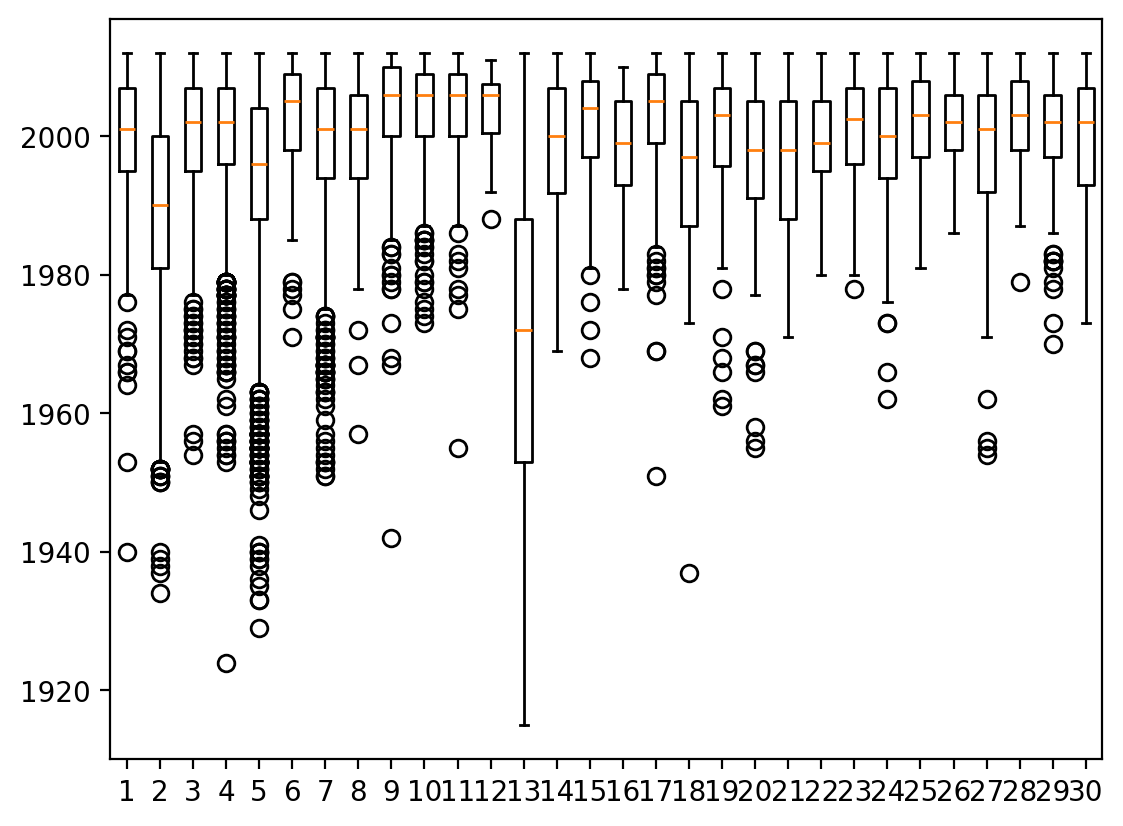

In [79]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

means = []
errs = []
cluster_years_list = []
for cluster in graph_stats.clusters:
    cluster_years = cluster.cluster_movies()["ReleaseDate"].apply(lambda x: int(x.year))
    if len(cluster_years) > 50:
        cluster_years_list.append(cluster_years)

ax.boxplot(cluster_years_list)
plt.show()

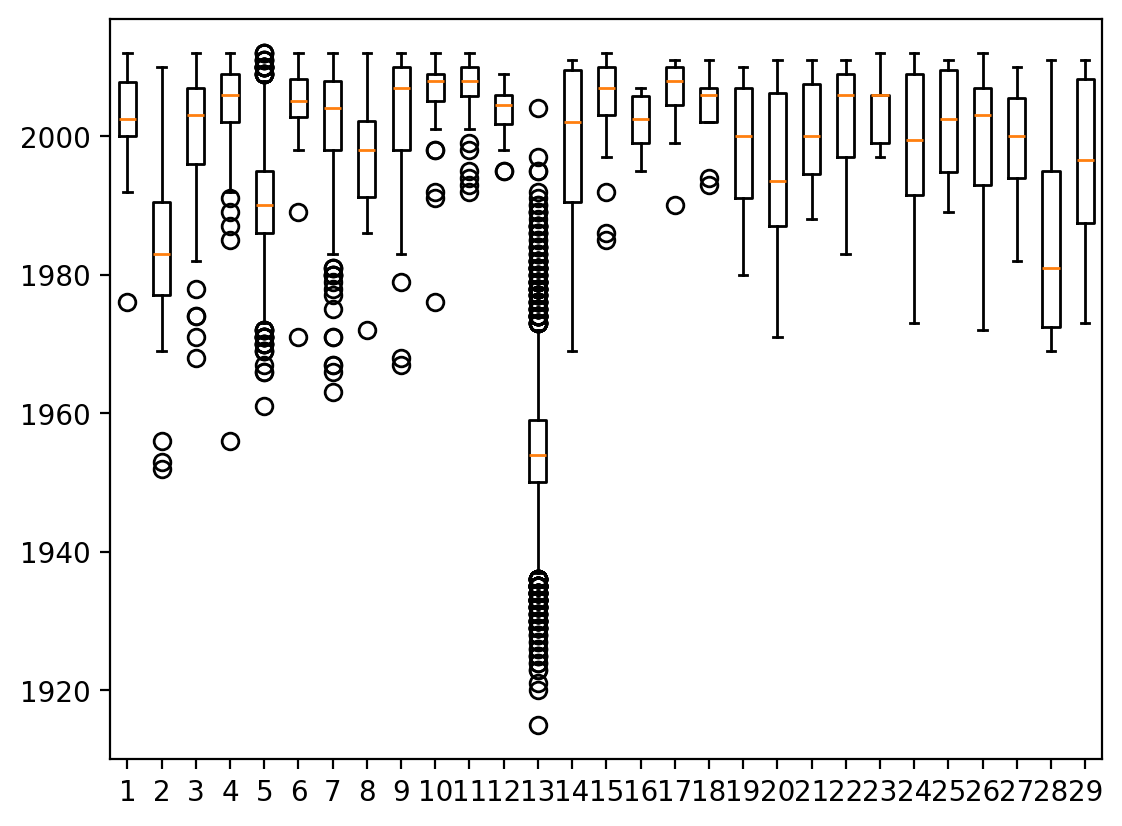

In [80]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

means = []
errs = []
cluster_years_list = []
for cluster in graph_stats.clusters:
    cluster_years = cluster.cluster_movies(select_type="half", num_actors_in_movie=us_num_actors_in_movie)["ReleaseDate"].apply(lambda x: int(x.year))
    if len(cluster_years) > 5:
        cluster_years_list.append(cluster_years)

ax.boxplot(cluster_years_list)
plt.show()

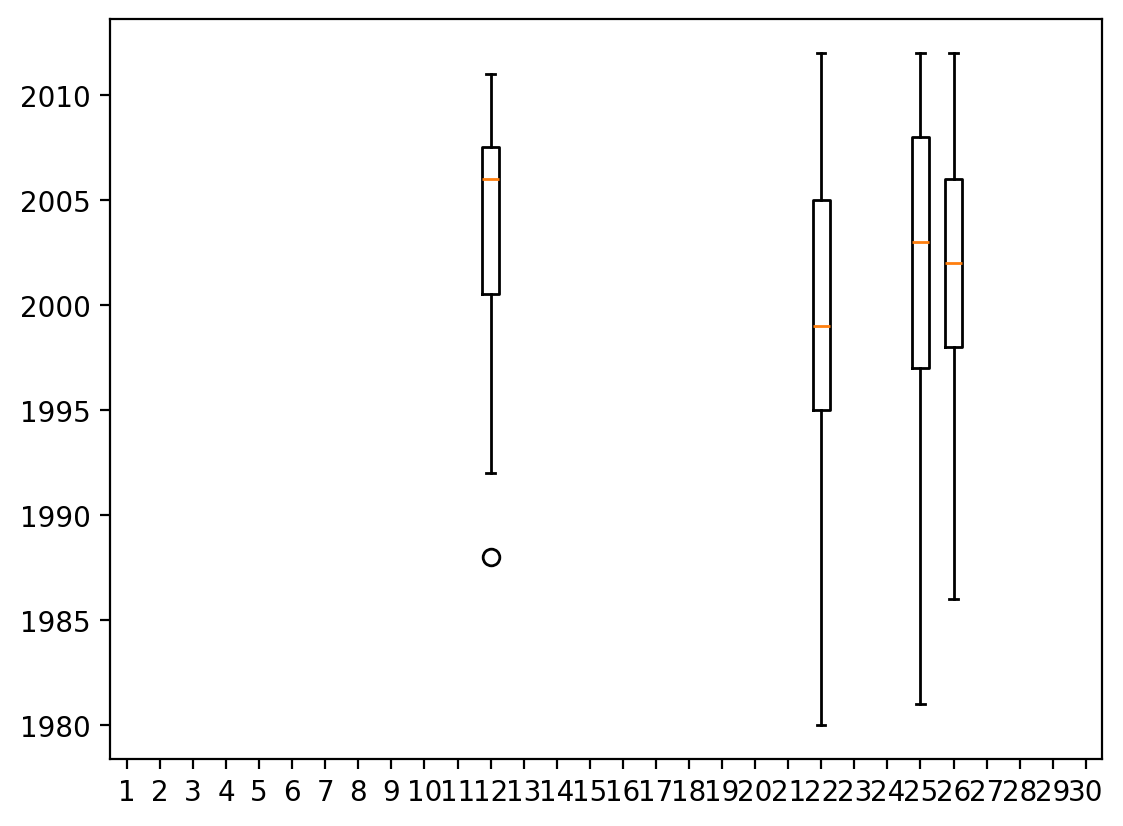

In [81]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

means = []
errs = []
cluster_years_list = []
for cluster in graph_stats.clusters:
    cluster_years = cluster.cluster_movies()["ReleaseDate"].apply(lambda x: int(x.year)).where(lambda x: x >= 1980)
    if len(cluster_years) > 50:
        cluster_years_list.append(cluster_years)

ax.boxplot(cluster_years_list)
plt.show()

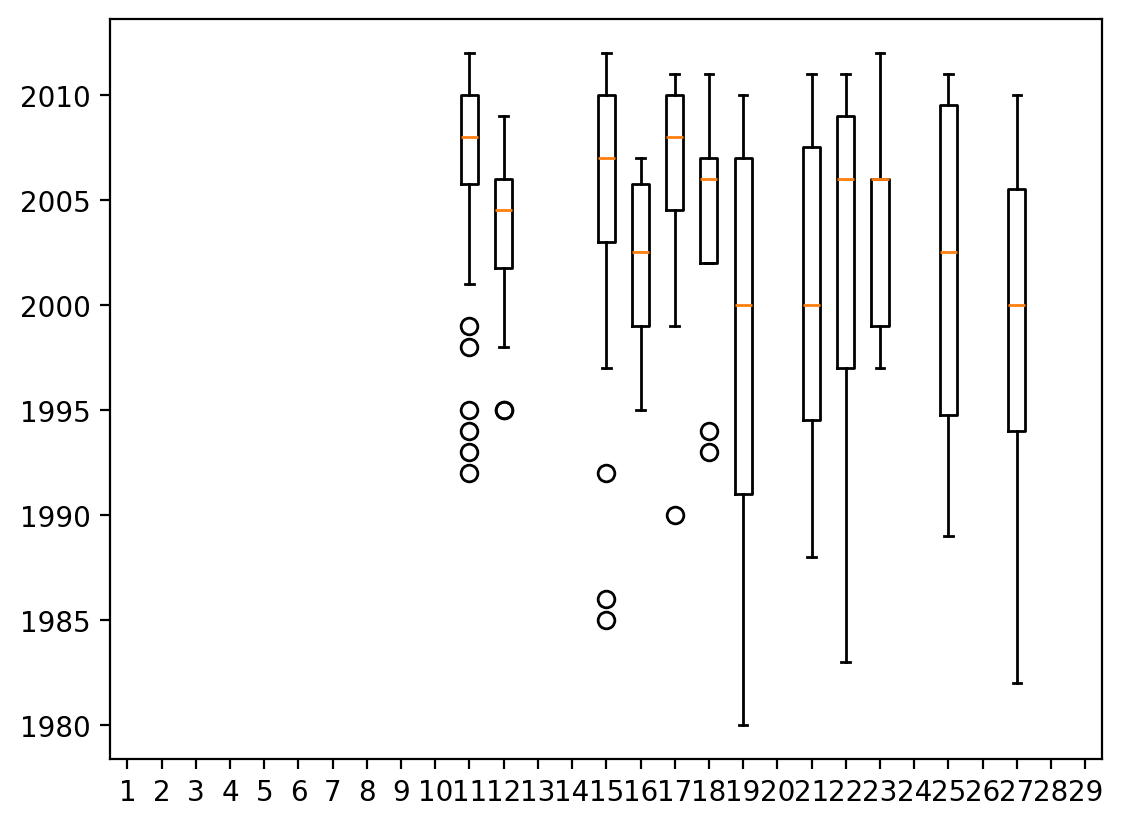

In [82]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

means = []
errs = []
cluster_years_list = []
for cluster in graph_stats.clusters:
    cluster_years = cluster.cluster_movies(select_type="half", num_actors_in_movie=us_num_actors_in_movie)["ReleaseDate"].apply(lambda x: int(x.year)).where(lambda x: x >= 1980)
    if len(cluster_years) > 5:
        cluster_years_list.append(cluster_years)
ax.boxplot(cluster_years_list)
plt.show()